In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
import eleanor

In [4]:
coords = (47.729, 9.8238)
#star = eleanor.Source(sector=4, coords = coords)


In [5]:
#data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

In [6]:
"""plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('CC CET');"""

"plt.figure(figsize=(15,5))\n\nq = data.quality == 0\n\nplt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')\nplt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')\nplt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')\nplt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')\nplt.ylabel('Normalized Flux')\nplt.xlabel('Time [BJD - 2457000]')\nplt.title('CC CET');"

In [7]:
#data.save(directory='eleanor_files/')

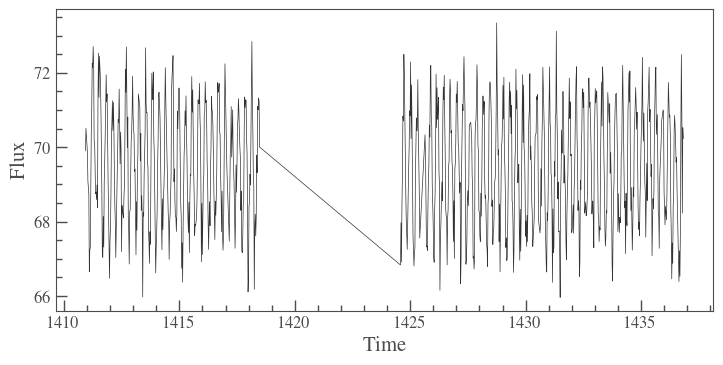

In [8]:
data = fits.getdata('eleanor_files/hlsp_eleanor_tess_ffi_tic337219837_s04_tess_v1.0.0_lc.fits')
q = (data['QUALITY'] == 0)
lc = lk.LightCurve(time = data['Time'][q], flux= data['CORR_FLUX'][q], flux_err = data['FLUX_ERR'][q])

#lc = data.to_lightkurve()
lc.plot()

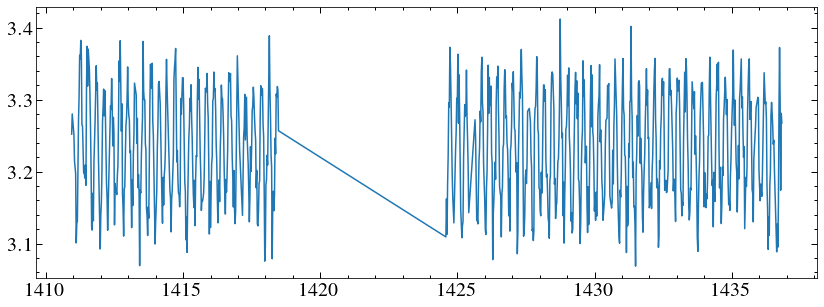

In [9]:
plt.plot(lc.time, lc.flux/lc.flux_err)

6.883503232597658 h


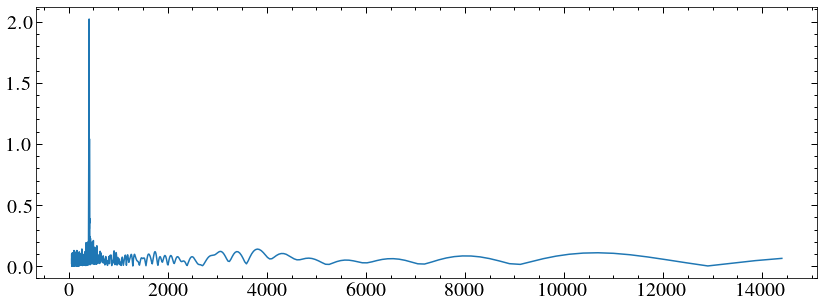

In [10]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=60*u.minute, maximum_period=10*u.day)
plt.plot(pg.period.to(u.minute), pg.power)
#plt.xscale('log')
print(pg.period_at_max_power.to(u.hour))
#plt.xlim((5*u.minute).to(u.hour).value, (35*u.minute).to(u.hour).value)
#plt.xlim(5, 75)

6.882712002560498 h


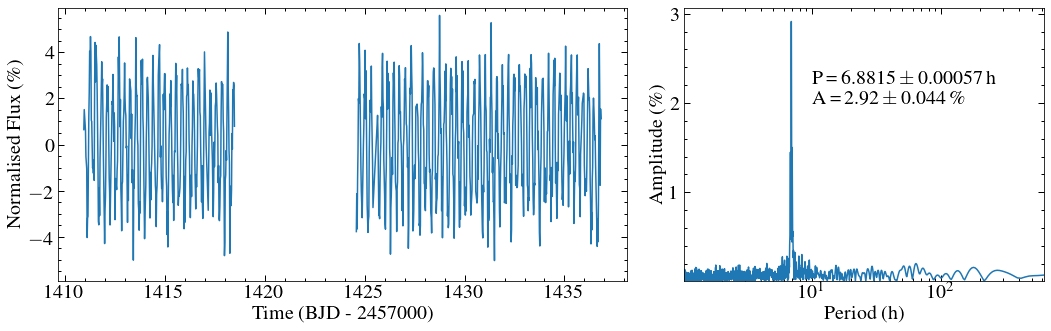

In [32]:
lc1 = lk.LightCurve(time = lc.time, flux= (lc.flux/np.median(lc.flux))-1, flux_err = lc.flux_err/np.median(lc.flux) )
pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=1*u.hour, maximum_period=(lc1.time[-1]-lc1.time[0])*u.day)
print(pg1.period_at_max_power.to(u.hour)) 
    
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 5, figure=fig)

plt.subplot(gs[:3])
#plt.plot(lc1.time, (lc1.flux)*100)
gap = 329
plt.plot(lc1.time[:gap], (lc1.flux[:gap])*100, c='C0')
plt.plot(lc1.time[gap:], (lc1.flux[gap:])*100, c='C0')
#plt.scatter(lc1.time[gap:], (lc1.flux[gap:])*100, c='C0')
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)

#plt.ylim(0.93, 1.07)
plt.ylim(-5.9, 5.9)

plt.subplot(gs[3:])
plt.plot(pg1.period.to(u.hour), pg1.power*100)
plt.xscale('log')
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
plt.xlim(1.01, 26*24)
#plt.annotate('P={0:10.2f}$\pm${}'.format(pg1.period_at_max_power.to(u.hour)), (10, 2.))
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.8815,0.00057, 2.92,  0.044), (10, 2.))
plt.ylim(0.01)

plt.tight_layout()
plt.savefig('plots/cc_cet_tess.pdf')

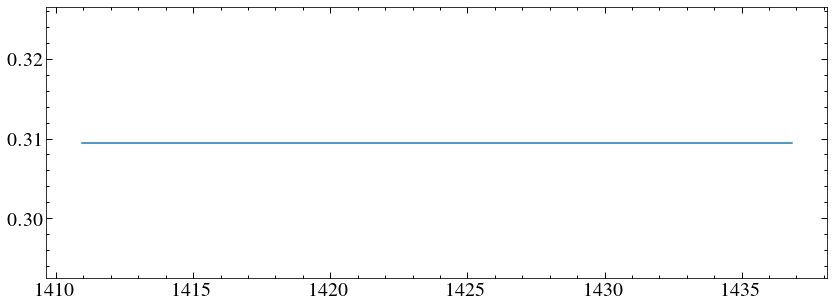

In [12]:
#plt.plot(np.arange(len(lc1.time)), lc1.time)
#plt.xlim(300, 350)
plt.plot(lc1.time, lc1.flux_err)

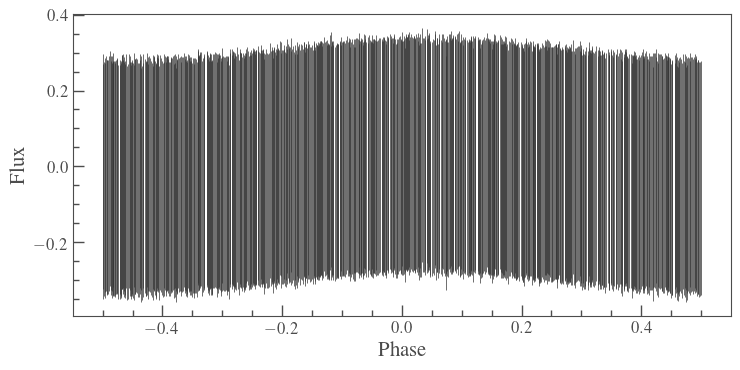

In [13]:
#lc2 = lc1.fold(pg1.period_at_max_power)
lc1.fold(pg1.period_at_max_power).errorbar()

Is there anything if we subtract out the orbital period?

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency             phase       
    -------------------- ------------------ -------------------
    0.029212765917992642 3.4876681108646053 -1.7464606309277202
[4.40179319e-04 2.87218306e-04 4.09206685e-01]
Period = 6.881388720800706 0.0005666997982131084 h
Amplitude = 2.921276591799264 0.044017931948413136


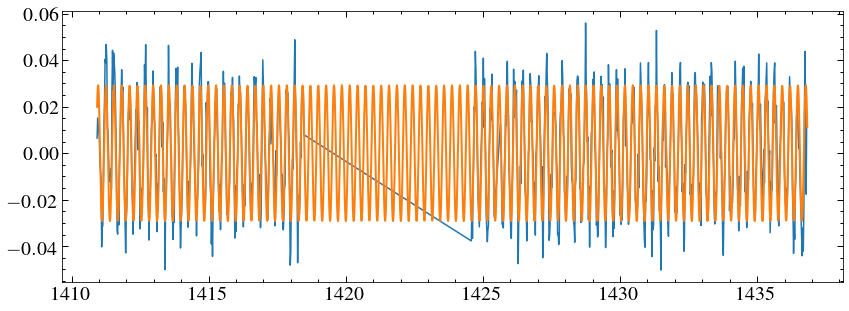

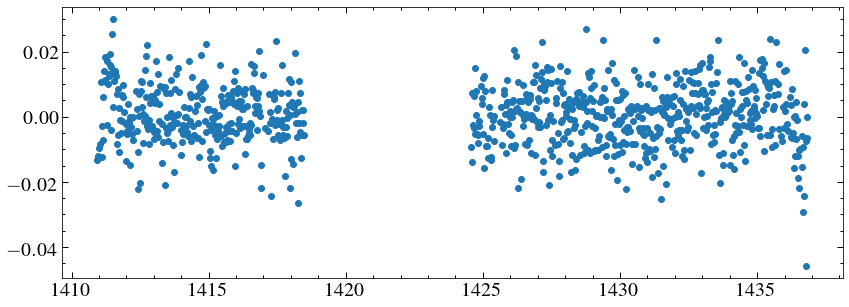

In [14]:
fitter = fitting.LevMarLSQFitter()


sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc1.time, lc1.flux, weights = 1/lc1.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 
timefit = np.linspace(lc1.time[0], lc1.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value*100, sin_fit_e[0]*100)
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude       frequency        phase       
    -------------------- --------- -------------------
    0.029087473634916195       1.0 -0.2203388398059728
[0.0003807 0.0020837]
Amplitude = 2.9087473634916194 0.03807042884140253


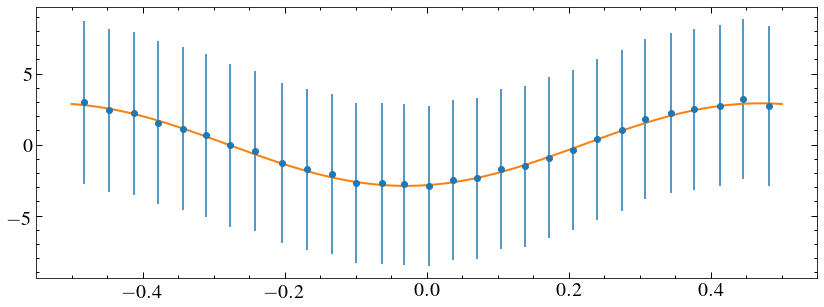

In [15]:
fitter = fitting.LevMarLSQFitter()

lcf = lc1.fold(pg.period_at_max_power.value).bin(30)
sin_modf =  models.Sine1D(amplitude=pg.max_power, frequency= 1, fixed=dict(frequency=True))#, bounds={'phase':[0, 2*np.pi]})
sin_fitf = fitter(sin_modf, lcf.time, lcf.flux, weights = 1/lcf.flux_err)
sin_fit_ef = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.errorbar(lcf.time, lcf.flux*100, yerr=lcf.flux_err*100, ls='none', marker='o')
timefit = np.linspace(-0.5, 0.5, 100)
plt.plot(timefit, sin_fitf(timefit)*100, c='C1', lw=2) 
print(sin_fitf)
print(sin_fit_ef)
#print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fitf.amplitude.value*100, sin_fit_ef[0]*100)
plt.show()
#plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))

/home/david/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


15.001484165827225 min


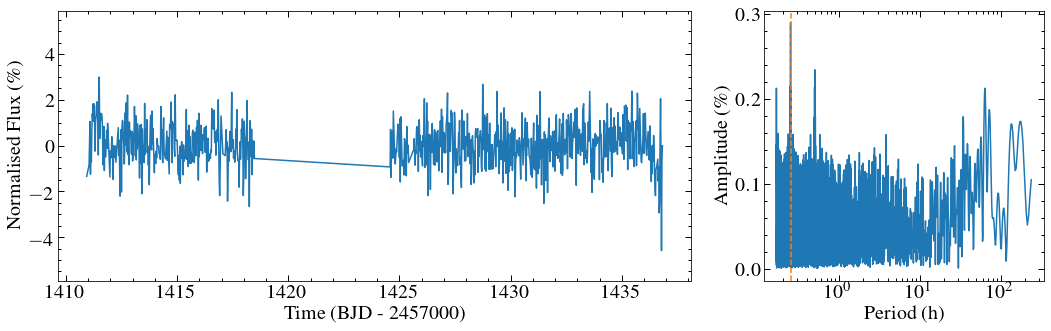

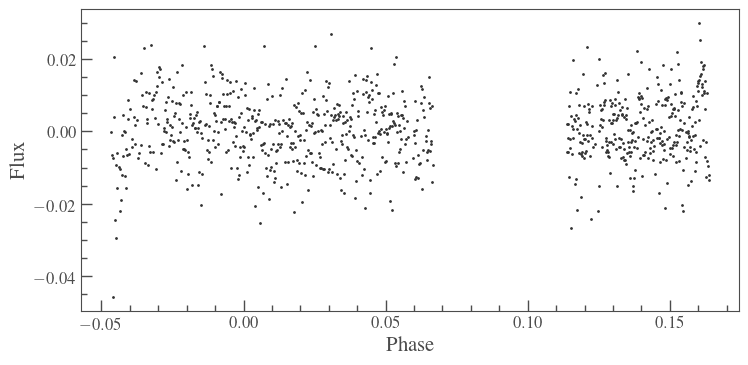

In [16]:
lc2 = lk.LightCurve(time = lc1.time, flux= lc1.flux-sin_fit(lc1.time), flux_err = lc1.flux_err)


pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=10*u.minute, maximum_period=10*u.day)
    
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, figure=fig)

plt.subplot(gs[:2])
plt.plot(lc2.time, (lc2.flux)*100)
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
#plt.ylim(0.93, 1.07)
plt.ylim(-5.9, 5.9)

plt.subplot(gs[2:])
plt.plot(pg2.period.to(u.hour), pg2.power*100)
plt.xscale('log')
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#plt.xlim(1.01, 109)
#plt.annotate('P={0:10.2f}\n(known binary \n period :( )'.format(pg2.period_at_max_power.to(u.hour)), (10, 2.))
print(pg2.period_at_max_power.to(u.minute))
plt.axvline(pg2.period_at_max_power.to(u.hour).value, ls='--', c='C1')
plt.tight_layout()
plt.show()
lc2.fold(pg2.period_at_max_power).scatter()

Nice plot for paper

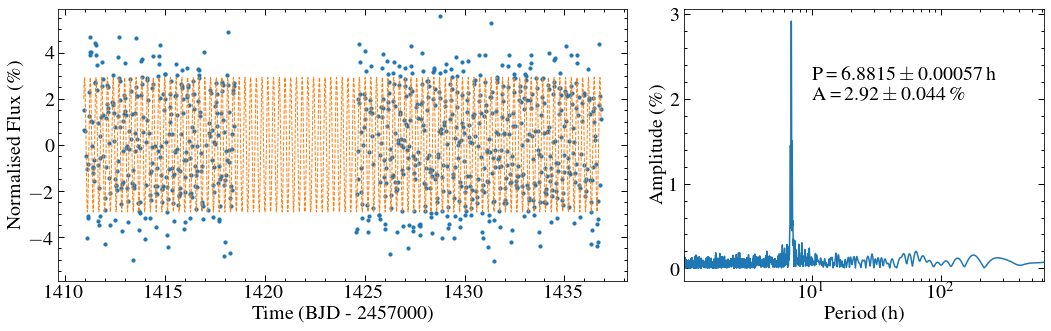

In [17]:
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 5, figure=fig)

plt.subplot(gs[:3])
#plt.plot(lc1.time, (lc1.flux)*100)
gap = 329
#plt.plot(lc1.time[:gap], (lc1.flux[:gap])*100, c='C0')
#plt.plot(lc1.time[gap:], (lc1.flux[gap:])*100, c='C0')
plt.scatter(lc1.time[gap:], (lc1.flux[gap:])*100, c='C0', s=10)
plt.scatter(lc1.time[:gap], (lc1.flux[:gap])*100, c='C0', s=10)
#plt.errorbar(lc1.time[:gap], (lc1.flux[:gap])*100, yerr=lc1.flux_err[:gap]*100, c='C0', marker='o', ls='none')
timefit = np.linspace(lc1.time[0], lc1.time[-1], 10000)
plt.plot(timefit, sin_fit(timefit)*100, c='C1', lw=1, ls='--') 
plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
#plt.xlim(1425, 1426)

#plt.ylim(0.93, 1.07)
plt.ylim(-5.9, 5.9)

plt.subplot(gs[3:])
plt.plot(pg1.period.to(u.hour), pg1.power*100)
plt.xscale('log')
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
plt.xlim(1.01, 26*24)
#plt.annotate('P={0:10.2f}$\pm${}'.format(pg1.period_at_max_power.to(u.hour)), (10, 2.))
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.8815,0.00057, 2.92,  0.044), (10, 2.))

plt.tight_layout()
#plt.savefig('plots/cc_cet_tess.pdf')

Not really, no. But good to see we can find the period, worth getting all of the other stars?

In [18]:
savdat = Table([lc.time, lc.flux, lc.flux_err], names=['#TIME(d)', 'COUNTS', 'ERROR'])
ascii.write(savdat, 'cc_cet_tess_s4_30m_lc.dat', format='basic', overwrite=True)

Got the COS lightcurve here as well

In [19]:
coslc = Table.read('CC_CET_COS_30s_lc.ecsv')
coslc.sort('TIME')

10.514552990053096 min


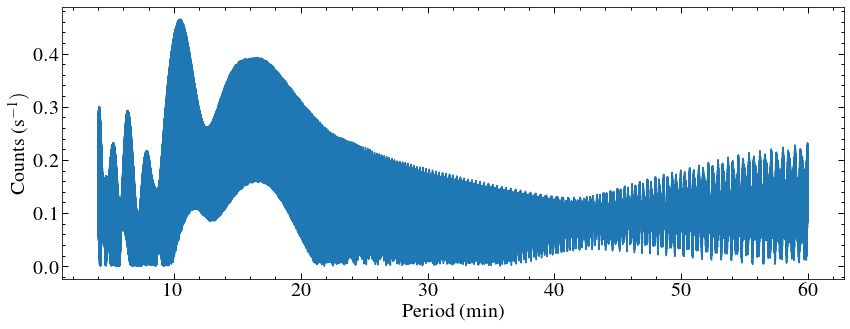

In [20]:

clc = lk.LightCurve(time=coslc['TIME'], flux=((coslc['FLUX']/np.mean(coslc['FLUX']))-1)*100, flux_err=(coslc['ERROR']/np.mean(coslc['FLUX']))*100).remove_outliers(sigma=5)
#clc = clc[:63]
#args = np.argsort(clc['TIME'])
#clc.sort()
cpg = clc.to_periodogram(oversample_factor=10,minimum_period=240*u.second, maximum_period=1*u.hour)
plt.plot(cpg.period.to(u.min), cpg.power)
plt.xlabel('Period (min)')
plt.ylabel('Counts (s$^{-1})$')

cperiod = cpg.period_at_max_power 
print(cperiod.to(u.min))

In [21]:
#clcfold = clc.fold(19/(24*60))
#clcfold.errorbar()

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude          frequency           phase       
    ------------------- ----------------- ------------------
    -0.5018843925013631 137.0910878442081 -8025.575259654138
[1.02244289e-01 3.81524681e-02 2.21804035e+03]
10.50396508368533 min


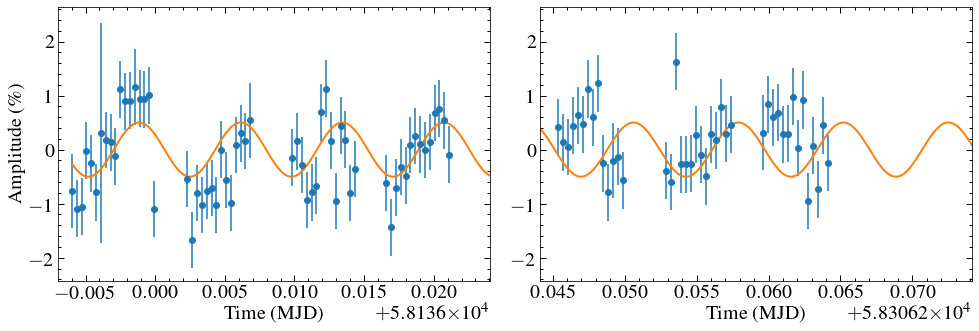

In [40]:
clc = lk.LightCurve(time=coslc['TIME'], flux=((coslc['FLUX']/np.mean(coslc['FLUX']))-1)*100, flux_err=(coslc['ERROR']/np.mean(coslc['FLUX']))*100).remove_outliers(sigma=5)
t1 = clc.time[-1]
clc1 = clc[:63]
sin_mod =  models.Sine1D(amplitude=cpg.max_power, frequency= cpg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod,clc1.time, clc1.flux, weights = 1/clc1.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.subplot(121)
plt.errorbar(clc.time, clc.flux, yerr=clc.flux_err, marker='o', ls='none') 
timefit = np.linspace(clc.time[0], t1, 1000000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(clc1.time[0]-0.001, clc1.time[0]+0.03)
print(sin_fit)
print(sin_fit_e)
print(((1/sin_fit.frequency)*u.day).to(u.min))
plt.xlabel('Time (MJD)')
plt.ylabel('Amplitude (\%)')

plt.subplot(122)
plt.errorbar(clc.time, clc.flux, yerr=clc.flux_err, marker='o', ls='none') 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(clc.time[-5]-0.02, clc.time[-5]+0.01)
plt.xlabel('Time (MJD)')
#plt.annotate('Fit to only 1st vist is in phase with 2nd')
plt.tight_layout()

Try just extracting from time-tag

<ErrorbarContainer object of 3 artists>

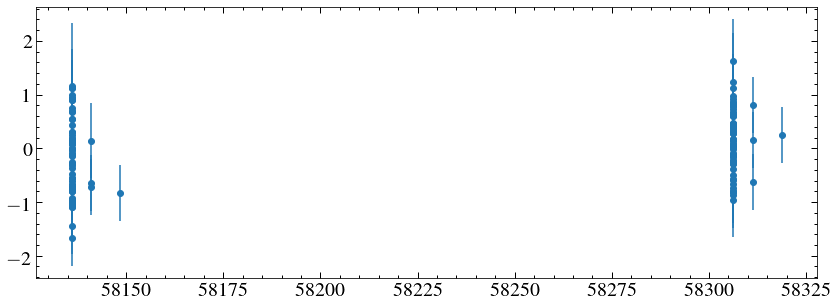

In [24]:
#lc_extractor.lc_maker(file_path = '/media/david/5tb_storage1/cc_cet/hst/data/', bin_time=5.)

In [25]:
#ct, cf, ce = np.loadtxt('lightcurves/V-CC-CET_FUV_58150.9936732_ldlc01xkq_5.0s_lc.dat', unpack = True)
#clc2 = Table.read('lightcurves/V-CC-CET_FUV_58150.9936732_ldlc01xkq_5.0s_lc.ecsv')
#ct, cf, ce = clc2['TIME']

#plt.errorbar(ct, cf, yerr=ce, marker='o', ls='none')
#plt.xlim(ct[0]-0.0005, ct[0]+0.001)

In [26]:
hdul = fits.open('eleanor_files/hlsp_eleanor_tess_ffi_tic337219837_s04_tess_v1.0.0_lc.fits')

In [27]:
hdul.info()

Filename: eleanor_files/hlsp_eleanor_tess_ffi_tic337219837_s04_tess_v1.0.0_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     217   ()      
  1                1 BinTableHDU     42   1060R x 16C   [D, D, 225E, 225E, D, D, D, K, D, D, D, D, E, K, D, D]   
  2                1 BinTableHDU     40   15R x 16C   [15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D, 15D]   
  3                1 BinTableHDU    104   1060R x 48C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [28]:
#hdul[0].header

In [29]:
0.286654*24

6.879696000000001

In [30]:
0.00000078*24

1.872e-05

In [31]:
1.9/24

0.07916666666666666

In [42]:
(4619.359351451899/1e6)*100

0.4619359351451899